# Tutorial Modelos de Ensamble tipo Random Forest

En este tutorial aplicaremos un modelo de ensamble tipo Random Forest a una serie de precios. Este tutorial se enfoca a generar una estructura en los datos que permita un pronóstico hacia adelante. Es decir, buscamos generar una estructura de ensamble a un conjunto de datos condicionados a eventos pasados, para luego generar un pronóstico futuro de los mismos. La serie por tanto genera una estructura de ensamble entrenada en una sección correspondiente de entrenamiento para luego generar un pronóstico hacia adelante en una estructura de datos transformada y mediante un modelo con refinamiento de parámetros.

**Contenido**
1. [Importación de librerías requeridas](#2)
1. [Importación de datos financieros](#3)
1. [Preprocesamiento de datos](#5)
1. [Partición de datos en entrenamiento y prueba](#6)
1. [Visualización conjunto de entrenamiento y prueba](#7)
1. [Regresión con Random Forest](#7a)
1. [Creación del Forecaster](#8)
1. [Predicciones en conjuto de prueba](#9)
1. [Refinamiento de los hiperparámetros](#10)
1. [Aplicación modelo óptimo a serie completa](#11)
1. [Generación del pronóstico hacia adelante](#12)
1. [Visualización del pronóstico futuro](#13)

<a id="2"></a> <br>
### 1. Importación de librerías requeridas

Importa las siguientes librerías para desarrollar este tutorial:

In [1]:
!pip install ipykernel
!pip install skforecast
!pip install skforecast[full]
#!pip install skforecast==0.11.0

In [2]:
#Esta es requerida para importar los datos financieros
!pip install yfinance

In [3]:
# Manipulación datos
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
#Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
warnings.filterwarnings('once')

In [4]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
##Si tienes problemas para descargar pandas datareader, puedes probar la siguiente línea:
!pip install git+https://github.com/pydata/pandas-datareader.git

  Cloning https://github.com/pydata/pandas-datareader.git to c:\users\dfgom\appdata\local\temp\pip-req-build-iuyjpffo
  Resolved https://github.com/pydata/pandas-datareader.git to commit a1cf7a20fe03dd63e930fa5ca1311a57897c9ddd
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/pydata/pandas-datareader.git 'C:\Users\dfgom\AppData\Local\Temp\pip-req-build-iuyjpffo'


<a id="3"></a> <br>
### 2. Importación de datos financieros

Establecemos primeramente la fecha de inicio y fin, así como el activo o los activos de interés. En este ejemplo, emplearemos únicamente un activo, pero dejo desactivados otros ejemplos de stocks (stks), índices (idx), monedas (ccy) como ejemplos de otros activos.

In [6]:
#Establecemos las fechas de consulta:
start = '2016-05-01'
end = '2018-01-28'
ticker = 'META'
#data = pdr.get_data_yahoo(ticker, start, end)['Adj Close']
#gs10='GS10'
#stks_tickers = ['AAPL','IBM', 'GOOGL']
#idx_tickers = ['SPY', '^DJI', '^VIX']
#ccy_tickers = ['JPY=X', 'GBPUSD=X']

In [7]:
#Una vez declarado el ticker, pedimos a través de la función de pandas data reader (pdr), bajar lso datos de la fuente de yahoo finance.
data = pdr.get_data_yahoo(ticker, start, end)['Close']

[*********************100%%**********************]  1 of 1 completed


In [8]:
#Pasamos a data frame los datos, cambiamos el nombre de la columna del tipo de precio a "y", para facilidad posterior.
dt= pandas.DataFrame(data)
df= dt.rename(columns={'Close': 'y'})
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 439 entries, 2016-05-02 to 2018-01-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       439 non-null    float64
dtypes: float64(1)
memory usage: 6.9 KB


In [9]:
df.head()

,y
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998


<a id="5"></a> <br>
### 3. Preprocesamiento de datos

En esta parte, debemos dar especial formato a la columna de fechas, así como a su frecuencia. Esto es importante para que el pronóstico mediante la función de regresión funcione apropiadamente. 

In [10]:
# Preparación formato datos
# ==============================================================================
dataindex= pd.to_datetime(df.index)
dataindex

DatetimeIndex(['2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-09', '2016-05-10', '2016-05-11',
               '2016-05-12', '2016-05-13',
               ...
               '2018-01-12', '2018-01-16', '2018-01-17', '2018-01-18',
               '2018-01-19', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26'],
              dtype='datetime64[ns]', name='Date', length=439, freq=None)

In [11]:
# Damos formato de fecha con periodiciadad diaria a la serie.
df['Date'] = pd.to_datetime(df.index, format='%Y-%m-%d')  
#df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  
df = df.set_index('Date')
df = df.asfreq('B')
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455 entries, 2016-05-02 to 2018-01-26
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       439 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [40]:
df.to_excel("DatosMeta.xlsx")

In [12]:
## Imputamos algún valor faltante con el valor anterior.
df.fillna(method='bfill', inplace=True)

In [13]:
# Podemos verificar si valores faltantes.
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


<a id="6"></a> <br>
### 4. Partición de datos en entrenamiento y prueba

En esta seción, partimos el conjunto de datos de pueba y de entrenamiento. 

In [14]:
# Split data into train-test
# ==============================================================================
steps = 22
data_train = df[:-steps]
data_test  = df[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

#Así también para las fechas:
date_train = dataindex[:-steps]
date_test = dataindex[-steps:]

Train dates : 2016-05-02 00:00:00 --- 2017-12-27 00:00:00  (n=433)
Test dates  : 2017-12-28 00:00:00 --- 2018-01-26 00:00:00  (n=22)


In [15]:
data_train.head()

,y
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998


In [16]:
#Identificamos la longitud de la serie
len(df)

455

In [17]:
data_train.head()

,y
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998


<a id="4"></a> <br>
### 5. Visualización de datos financieros

Para mirar la serie, debemos importar la librería de matplotlib.

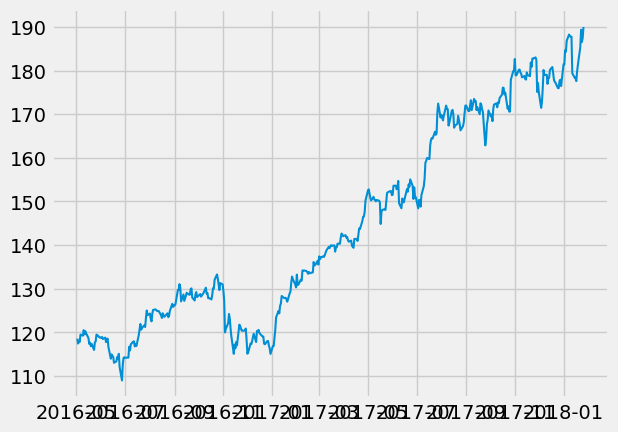

In [18]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.plot(df)

In [19]:
#Vemos los datos para las fechas que nos sirven para las gráficas
date_train
#date_test  #Igualmente para visualizarlos

DatetimeIndex(['2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-09', '2016-05-10', '2016-05-11',
               '2016-05-12', '2016-05-13',
               ...
               '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22'],
              dtype='datetime64[ns]', name='Date', length=417, freq=None)

<a id="7"></a> <br>
### 6. Visualización conjunto de entrenamiento y prueba

In [20]:
#Imprimimos la longitud de ambos conjuntos de datos:
print(len(data_train))
print(len(data_test))

433
22


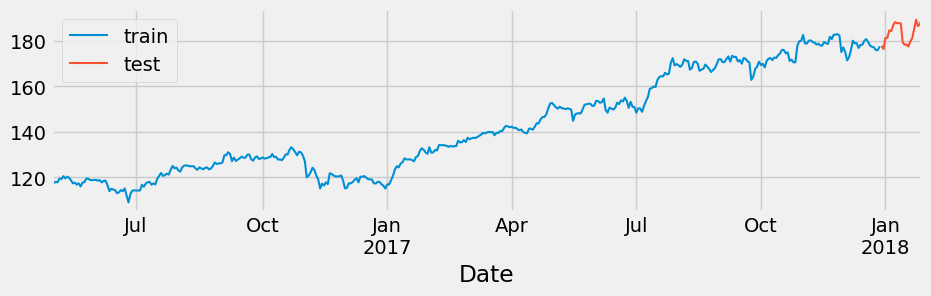

In [21]:
fig, ax = plt.subplots(figsize=(10, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

Ahora verificamos como quedo la partición de nuestra serie de tiempo.

In [22]:
#Otra opción, es emplear la librería de go.Scatter para otro tipo de gráfico. 
trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'test'
)

layout = go.Layout(
    title = "Bond ",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

<a id="7a"></a> <br>
# 6. Regresión con Random Forest
En esta sección, comenzaremos la regresión empleando el algoritmo de Random Forest. Para ello, comenzaremos con la creación de la estructura de datos tipo aprendizaje supervisado. Esto se hace mediante la función de ForecasterAutoreg.

<a id="8"></a> <br>
### 7. Creación del Forecaster

En esta sección aplicamos la función de Forecast Aurtoregress para la creación de ventanas con ciertos retrazos al cual se aplica el modelo de Random Forest. En este caso, consideramos 10 retrazos que capturan la estructura de datos de la serie y generan un pronóstico a 10 días. Esto significa que el modelo emplea los 10 días previos como predictores. Así, por ejemplo, si se tuviera una sección de prueba de 6 días, con un tamaño de ventana de 3 rezagos, la dimensión del conjunto de datos de prueba cuando se entrenara el modelo sería de (6x3):
* "Train"  "Pron"
* [1,2,3]   [4]
* [2,3,4]   [5]
* [3,4,5]   [6]
* [4,5,6]   [7]
* [5,6,7]   [8]
* [6,7,8]   [9]


In [23]:
# Creamos y entrenamos el modelo de Random Forest con la función de estructura de datos generada a través de la función Forecaster, en este caso, creando ventanas de 10 días:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 10
                )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-05-02 00:00:00'), Timestamp('2017-12-27 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: B 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-12 17:40:56 
Last fit date: 2024-05-12 17:40:56 
Skforecast version: 0.11.0

<a id="9"></a> <br>
### 8. Predicciones en conjunto de prueba


Verifiquemos el rendimiento del modelo entrenado en el conjunto de test o prueba.

In [24]:
# Pronóstico, en este caso elegimos una ventana de n-test días.
# ==============================================================================
steps = 22  ## el mismo que la ventana de test
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2017-12-28    177.732099
2017-12-29    178.673100
2018-01-01    179.720800
2018-01-02    179.477599
2018-01-03    179.397800
Freq: B, Name: pred, dtype: float64

Hasta aquí, es improtante verificar que el pronóstico esté indexado por la fecha, en la frecuencia adecuada. Con ello, el refinamiento de los parámetros es posible.

In [25]:
# Determinamos el error de pronóstico:
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
RMSE = sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 35.43613506208935
Test error (rmse): 5.952825804782914


<a id="10"></a> <br>
### 9. Refinamiento de los hiperparámetros

La función que entrena los datos emplea la configuración sugerida por el usuario donde el modelo de Random Forest aplica la configuración por default de los hiperparámetros. Sin embargo, no existe sustento que esta configuración sea la ideal. Por tanto y para encontrar la mejor combinación de retrazos e hiperparámetros, podemos emplear la librería de Skforecast la cual provee la función de búsqueda con los parámetros que minimicen la métrica de error. Con esta configuración, podemos posteriormente ajustar el modelo para el pronóstico.

In [36]:
# Cálculo de hiperparámetros por grid search
# ==============================================================================
steps = 22
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 # Este valor se reemplazará en la grilla
             )

# Lags used as predictors
lags_grid = [10]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 19.196979987164895



In [37]:
# Visualizamos los resultados del grid search
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",19.196980,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",20.069863,10,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",20.163986,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",21.244425,10,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",31.822233,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",31.944641,3,100


<a id="11"></a> <br>
### 10. Aplicación modelo óptimo a serie completa

A partir de la salida anterior, ¿cuáles deberían las variables a escoger para entrenar el modelo?

In [28]:
# Configuramos la función de pronóstico de forecaster con la mejor combinación obtenida de hiperparámetros.
# ==============================================================================
### Aquí debe ir tu codigo, 
regressor = RandomForestRegressor(max_depth= 10, n_estimators=100 , random_state=123)


forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 1
                )

#forecaster.fit(y=df['y'])
#f = forecaster.fit(y=df['y'])



In [39]:
forecaster.fit(y=data_train['y'])
steps = 22  ## el mismo que la ventana de test
predictions = forecaster.predict(steps=steps)
predictions.to_excel("RF.xlsx")



In [30]:
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
RMSE = sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 40.27471487212863
Test error (rmse): 6.346236276103233


In [31]:
# Podemos imprimir la importancia de los rezagos

#print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
forecaster.get_feature_importances()

,feature,importance
0,lag_1,1.0


Como podemos ver, los primeros tres rezagos son los que más aportan al modelo.

<a id="12"></a> <br>
### 11. Generación del pronóstico hacia adelante

Una vez que el modelo es entrenado, se genera el pronóstico futuro.

In [32]:
# Pronóstico, en este caso elegimos una ventana de 12 días.
# ==============================================================================
steps = 12
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2017-12-28    177.754637
2017-12-29    178.910202
2018-01-01    179.378610
2018-01-02    178.358433
2018-01-03    179.531740
Freq: B, Name: pred, dtype: float64

In [33]:
fin = data_test.index.max() 
fin

Timestamp('2018-01-26 00:00:00')

In [34]:
## Generamos las fechas a dichos pronósticos mediante la función de pandas date_range:
fin = data_test.index.max()   #Partimos de la fecha máxima de la sección de prueba, hacia adelante.
fwd_dates = pd.date_range(fin, periods=12, freq='D').tolist()
fwd_dates

[Timestamp('2018-01-26 00:00:00'),
 Timestamp('2018-01-27 00:00:00'),
 Timestamp('2018-01-28 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-01-30 00:00:00'),
 Timestamp('2018-01-31 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-02-02 00:00:00'),
 Timestamp('2018-02-03 00:00:00'),
 Timestamp('2018-02-04 00:00:00'),
 Timestamp('2018-02-05 00:00:00'),
 Timestamp('2018-02-06 00:00:00')]

<a id="13"></a> <br>
### 12. Visualización del pronóstico futuro

A continuación verás graficamente las tres series de tiempo (train, test y forecast). El gráfico es interactivo, amplia la zona donde están las series de test y forecast.

In [35]:
## Graficamos la serie anterior, aunando el valor del pronóstico.

trace3 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'Test'
)

trace4 = go.Scatter(
    x = fwd_dates,
    y = predictions,
    mode = 'lines',
    name = 'Pronóstico Futuro Random Forest'
)

trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Train'
    )

layout = go.Layout(
    title = "AMZN",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace3, trace4], layout=layout)
fig.show()

En este tutorial aprendiste un proceso para la generación de pronósticos futuros de una serie financiera mediante modelos de ensamble tipo Random Forest. En el proceso, reiteramos la importancia de transformar los datos de una serie de tiempo en una estructura de datos que permiten generar secuencias de entrenamiento y pronóstico de la serie con base en datos históricos. Este proceso se debe hacer especialmente cuando deseamos generar un pronóstico hacia adelante en series de tiempo. Dicho proceso es muy similar al que se emplea cuando aplicamos un problema supervisado tal como una regresión lineal o modelos regresivos, donde se generan los retrasos o lags de la serie y cuyos features ingresan al modelo de regresión. En este caso, se crea una estructura en la cual se puede emplear para entrenar un modelo de ensamble cuyo proceso puede ser tedioso. Para ello, existen funciones que ayudan es esa tarea, en el caso particular de este tutorial, empleamos la función de Forecaster Autoregressor que crea la estructura de datos y aplica el modelo de Random Forest con los parámetros suministrados. Una vez obtenido el modelo se genera el pronóstico futuro especificando la serie a emplear.

**Referencia:**

 Este tutorial emplea la función ForecasterAutoreg de la paquetería skforecast (https://pypi.org/project/skforecast/). 
 
 Ceballos, F. 2019. Stacking classifiers for higher predictive performance. Towards Data Science. Retrieved from: https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840 